# Exploratory Data Anaylsis

This notebook explores the data provided as part of the Kaggle SETI Breakthrough listen competition:
- https://www.kaggle.com/competitions/seti-breakthrough-listen

## Install Python Packages

In [1]:
# Utility packages
import os

# Helps load training data
import numpy as np

# Plots images
import matplotlib.pyplot as plt

# Used for data wrangling
import pandas as pd

# Plots charts
import plotly.express as px

# Decomposes images into factor matrices.
# Used for removing background noise
from sklearn.decomposition import NMF

## Load Data

Load the training data labels from disk:

In [2]:
data_dir = r'D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Data\train'
labels_df = pd.read_csv(os.path.join(data_dir, '_labels.csv'), delimiter=',')

Helper functions for loading image data:

In [3]:
'''
Returns the file path from an image sample ID.
'''
def get_image_path(data_directory, file_id):
    path = os.path.join(data_directory, file_id[0], f'{file_id}.npy')

    return path



'''
Returns the data for a sample image.
'''
def get_image_data(data_directory, file_id):
    file_path = os.path.join(data_directory, file_id[0], f'{file_id}.npy')

    if os.path.exists(file_path):
        return np.load(file_path)

    return

## Label Data

Load the label data into a new dataframe, with a new `file_path` column containing the location of the sample image data:

In [4]:
data_df = labels_df.copy()

data_df['file_path'] = labels_df['id'].apply(lambda x: get_image_path(data_dir, x))

In [5]:
data_df.head()

,id,target,file_path
0,0000799a2b2c42d,0,D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...
1,00042890562ff68,0,D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...
2,0005364cdcb8e5b,0,D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...
3,0007a5a46901c56,0,D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...
4,0009283e145448e,0,D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...


## View Sample Image

Locate a positive sample so that it can be visualised:

In [6]:
positive_sample = data_df[data_df.target == 1].iloc[2]
positive_sample_images = np.load(positive_sample['file_path']).astype(np.float32)

We can see from the shape of the loaded image data, that it consists of 6 grayscale images with resolution 237x256:

In [7]:
np.shape(positive_sample_images)

(6, 273, 256)

Plot the image in "grayscale":

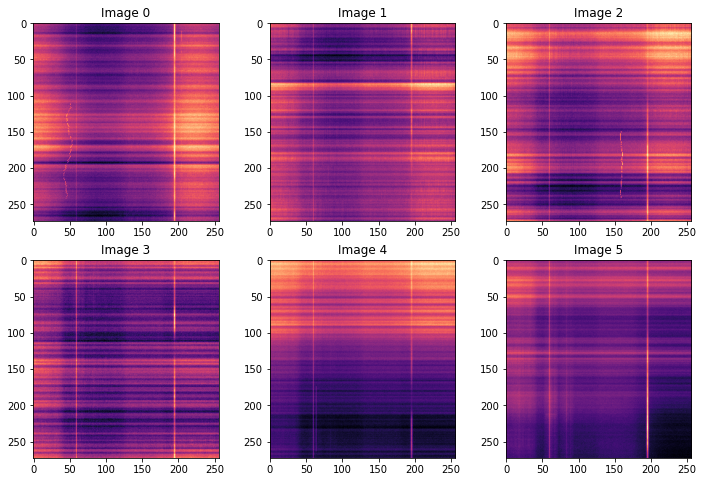

In [8]:
f, ax = plt.subplots(2,3, figsize=(12,8))

# iterate through each image in sample and display it
for i in range(len(positive_sample_images)):
    row = i // 3
    column = i - row * 3
    
    ax[row, column].set_title('Image ' + str(i))
    ax[row, column].imshow(positive_sample_images[i], cmap=plt.get_cmap('magma'))

There are 6 images because each data sample consists of 6 spectograms.

These spectograms are for observations of 3 different targets, **A**, **B** and **C**.

The sequence of the observations is **ABACAD**.

The target **A** is referred to as the on target, and is the target of interest.

The other targets are observed to help eliminate interference noise, by proving that an interesting signal is only coming from **A**.

## Image Denoising

The main challenge with the dataset is that there is a lot of background noise and interference.

Another challenge is that the signals we want to classify are relatively weak.

To help alleviate the background noise a denoising technique can be applied, based on:
- https://www.kaggle.com/competitions/seti-breakthrough-listen/discussion/245950

This works by decomposing the images into their factor matrices.

Then the noise is calculating by using the product of on target and on target decomposed matrices.

This noise is then subtracted from the on target image:

In [49]:
'''
Min-max normalises the image pixel values (between 0 and 1).
'''
def normalise_image(image):
    image_min = image.min()
    image_max = image.max()

    return (image - image_min) / (image_max - image_min)



'''
Factorises an image into two matrices, and returns them.
Used to help remove image background noise.
'''
def get_decomposition_matrices(image):
    model = NMF(n_components=2, init='random', random_state=0)
    W = model.fit_transform(image + 100) # add 100 to ensure no negative values
    H = model.components_

    return (W, H)



'''
Removes the background noise from a set of sample images.

Based on: https://www.kaggle.com/competitions/seti-breakthrough-listen/discussion/245950
'''
def get_denoised_image(sample_images):
    denoised_images = []

    for i in range(0, len(sample_images), 2):
        on_target_image = sample_images[i] # Get on target image
        off_target_image = sample_images[i+1] # Get off target image

        on_W, on_H = get_decomposition_matrices(on_target_image) # Decompose on target images into factor matrices
        off_W, off_H = get_decomposition_matrices(off_target_image) # Decompose off target images into factor matrices

        # Get noise approximation by multiplying a factor matrix from each of the on target, and off target images.
        # Then subtract the approximated noise from the on target image
        denoised_image = normalise_image(on_target_image - np.matmul(on_W, off_H))
        denoised_images.append(denoised_image)

    # combine the 3 denoised on target images by appending them horizontally
    denoised_images = np.array(denoised_images)
    combined_image = np.hstack(denoised_images.reshape(3, 273, 256))

    return combined_image

We can visualises how effectively the background noise was removed from our selected positive sample:

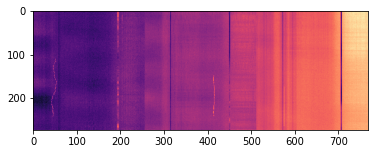

In [50]:
denoised_image = get_denoised_image(positive_sample_images)

plt.imshow(denoised_image, cmap=plt.get_cmap('magma'))

This shows that it has managed to remove a large amount of noise, which will allow a model to focus on salient features more easily.

## Data Distribution

Display the distribution of negative and positive samples to see if they are balanced:

In [ ]:
data_distribution = labels_df.target.map({0: 'Negative samples', 1: 'Positive samples'})
data_distribution = data_distribution.value_counts()

px.pie(data_distribution, names=data_distribution.index, values='target', title='Original Data Distribution')

There is a clear abundance of negative samples compared to positive ones.

In [ ]:
data_distribution

Since positive samples only make up 10% of the dataset, the model will be able to achieve 90% accuracy simply by predicting a sample is negative each time.

To mitigate this 6000 random negative samples are chosen alongside the 6000 positive ones to balance the data:

In [ ]:
train_data_df = data_df.query('target == 0').sample(n=6000)
train_data_df = train_data_df.append(data_df.query('target == 1'))

`train_data_df` is now balanced with 6000 positive and 6000 negative samples:

In [ ]:
train_data_df.target.map({0: 'Negative samples', 1: 'Positive samples'}).value_counts()

Save the balanced training set to file:

In [ ]:
save_location = os.path.join(data_dir, '12000_balanced_labels.npy')

with open(save_location, 'wb') as f:
    np.save(f, train_data_df)